<a href="https://colab.research.google.com/github/svondracek0/dtse-applied-ts/blob/master/airline_analysis/airline_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aplikovaná analýza časových řad s DTSE AIS

V tomto kurzu se seznámíte s konceptem analýzy časových řad a prognózování. Naučíte se, jak používat data časových řad k předpovídání budoucích hodnot pomocí statistických modelů.
Naučíte se také vyhodnocovat výkonnost modelů a vybrat optimální model pro prognózování. K tomu budeme používat některé standardní knihovny v jazyce Python, jako jsou pandas, numpy, matplotlib, sktime a statsmodels.

## 1 Časové řady a jejich vlastnosti
V této části budeme používat soubor dat o leteckých společnostech, který obsahuje informace o celkovém počtu cestujících leteckých společností v období 1949-1960.

In [1]:
# this code cell is used to import the necessary libraries (it is a good practice to do this in the beginning of the notebook)
from sktime.datasets import load_airline
from pmdarima.datasets import load_lynx
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.linear_model import LinearRegression
from sktime.forecasting.arima import ARIMA
from statsmodels.tsa.statespace.tools import diff
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error


### 1.1 Načtení a prezentace souboru dat
Je důležité načíst datovou sadu a prezentovat ji tak, abychom porozuměli datům a jejich vlastnostem. Časové řady se obvykle vizualizují pomocí čárových grafů, i když nad agregovanými/dezagregovanými daty lze použít sofistikovanější metody, jako např.
svíčkové grafy atd.

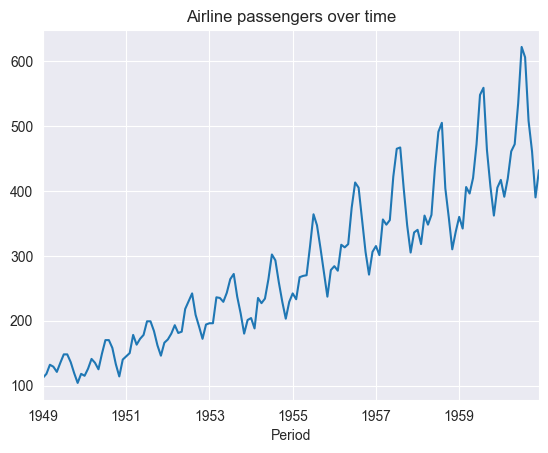

In [2]:
airline = load_airline()
airline.index = airline.index.to_timestamp()  # convert the period index to timestamp
fig = airline.plot(title='Airline passengers over time')
plt.show()

In [3]:
# length of our time series
print(airline.shape)

(144,)


In [4]:
# periodicity of the time series
airline.index[1] - airline.index[0]

Timedelta('31 days 00:00:00')

In [5]:
144 / 12

12.0

Jaké jsou tedy charakteristiky, které odlišují časové řady od jiných forem datových souborů?
- Data časových řad jsou uspořádaná, což znamená, že pořadí datových bodů je důležité.
- body jsou obvykle rovnoměrně rozmístěny v čase (obvyklé algoritmy tuto vlastnost potřebují, což lze zajistit během předzpracování)
- časové řady mohou být jednorozměrné i vícerozměrné, dnes se zaměříme na jednorozměrné časové řady
- časové řady mají určité vlastnosti, kterými se budeme zabývat v následující části

### 1.2 Základní vlastnosti časových řad
Časové řady mohou mít různé vlastnosti, z nichž se dnes zaměříme na následující:
- Trend: dlouhodobý nárůst nebo pokles údajů.
- Sezónnost: vzorec, který se opakuje v pravidelných intervalech (např. denních, týdenních, měsíčních, ročních).
- TODO: Mohli byste vymyslet nějaké příklady pro každou z těchto kategorií?


Řešení:
- denní sezónnost: počet lidí navštěvujících park
- týdenní sezónnost: počet lidí navštěvujících kostel
- měsíční sezónnost: počet lidí, kteří jdou na poštu (např. vyzvednout si nájem)
- roční sezónnost: prodej hraček

In [6]:
airline_decomposed = seasonal_decompose(airline, period=12)

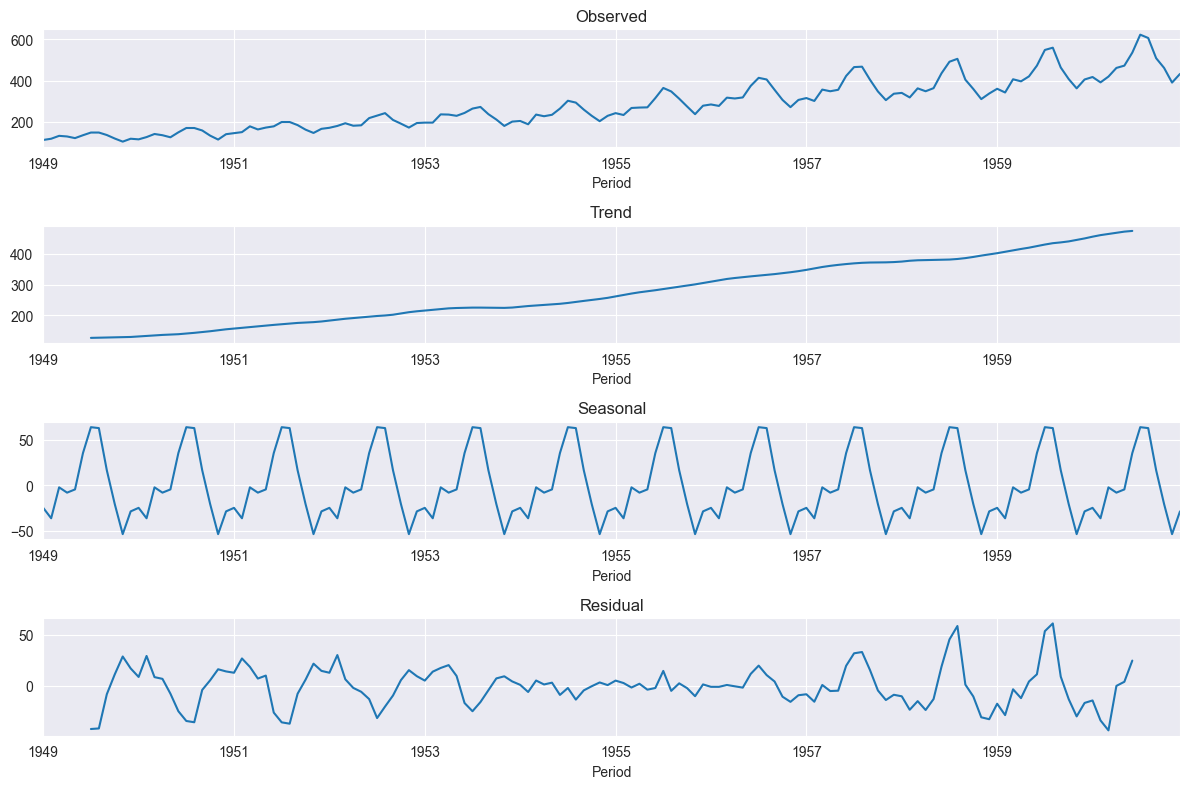

In [7]:
fig, axes = plt.subplots(4, 1, figsize=(12, 8))

airline_decomposed.observed.plot(ax=axes[0], legend=False)
axes[0].set_title('Observed')
airline_decomposed.trend.plot(ax=axes[1], legend=False)
axes[1].set_title('Trend')
airline_decomposed.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_title('Seasonal')
airline_decomposed.resid.plot(ax=axes[3], legend=False)
axes[3].set_title('Residual')

plt.tight_layout()
plt.show()

### 1.3 Pokročilé vlastnosti časových řad

Kromě základních vlastností mohou mít časové řady i pokročilejší vlastnosti, jako jsou:
- Autokorelace: korelace časové řady se zpožděnou verzí sebe sama.
- Částečná autokorelace: korelace časové řady se zpožděnou verzí sebe sama po odstranění vlivu mezilehlých zpoždění.
- Stacionarita: vlastnost časové řady, kdy se střední hodnota, rozptyl a autokorelační struktura v čase nemění.
- Hetereoskedasticita: vlastnost časových řad, kdy se rozptyl časové řady v čase mění.

#### 1.3.1 Autokorelace
Autokorelace je míra toho, jak je časová řada korelována se svou zpožděnou verzí. Je to užitečná vlastnost
pochopení základní struktury časové řady a lze ji použít k určení řádu autoregresního modelu.

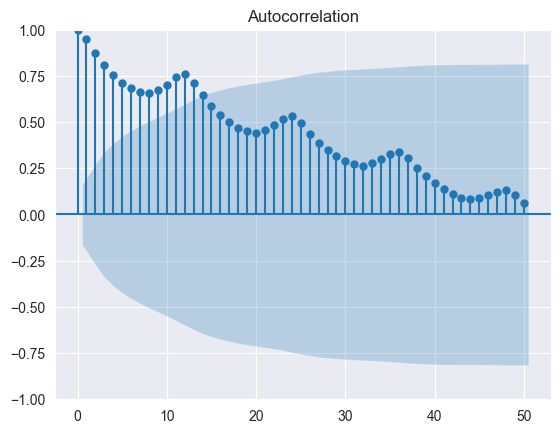

In [8]:
plot_acf(airline, lags=50)
plt.show()

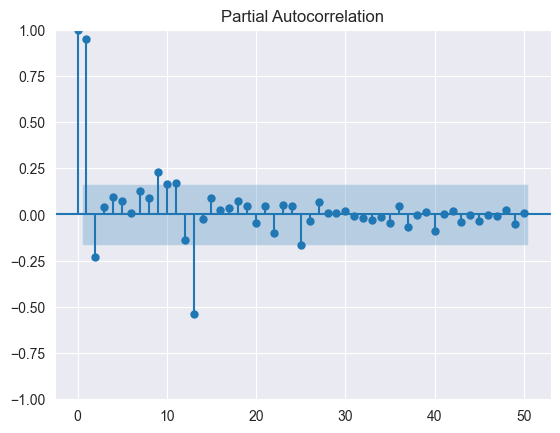

In [9]:
plot_pacf(airline, lags=50)
plt.show()

### 1.3.2 Stacionarita
Stacionarita je vlastnost časových řad, kdy se střední hodnota, rozptyl a autokorelační struktura v čase nemění.
Je to důležitá vlastnost pro analýzu časových řad, protože mnoho modelů časových řad předpokládá, že časová řada je stacionární.
Lze ji testovat pomocí rozšířeného Dickey-Fullerova testu.

In [10]:
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(airline)
print(adf_result[1])

0.991880243437641


Hodnota p rozšířeného Dickey-Fullerova testu je 0,99, což je více než 0,05. To znamená, že se nám nepodařilo zamítnout nulovou hypotézu, že časová řada je nestacionární. Můžeme tedy předpokládat, že časová řada je nestacionární a že před modelováním budeme možná muset provést nějakou transformaci. K tomu se dostaneme při hodnocení kvality našich modelů

### 1.3.3 Hetereoskedasticita
Hetereoskedasticita je vlastnost časových řad, kdy se rozptyl časové řady v čase mění. Je to důležitá vlastnost, kterou je třeba brát v úvahu při modelování dat časových řad, protože může ovlivnit výkonnost modelu. Lze ji testovat pomocí ARCH testu.

In [11]:
from statsmodels.stats.diagnostic import het_arch
print(het_arch(airline)[1])

2.9612337605031027e-22


The very low p-value of the ARCH test indicates that the time series is heteroskedastic. This means that the variance of the time series changes over time and we might need to do some transformation before the modelling.

### 1.4 Transforming the time series
In this section, we will transform the series to make it at least stationary. To do so, we will use seasonal differencing.

In [12]:
diff_airline = airline.diff().dropna()

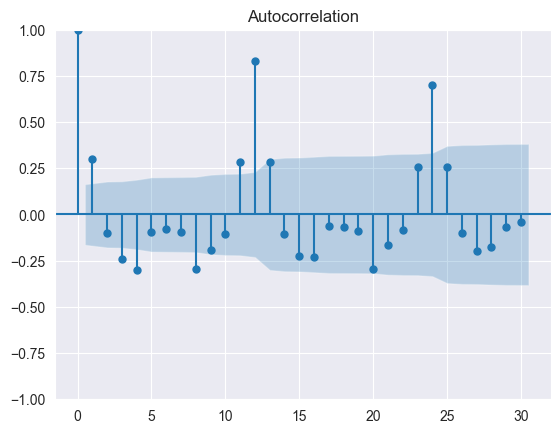

In [13]:
plot_acf(diff_airline, lags=30)
plt.show()

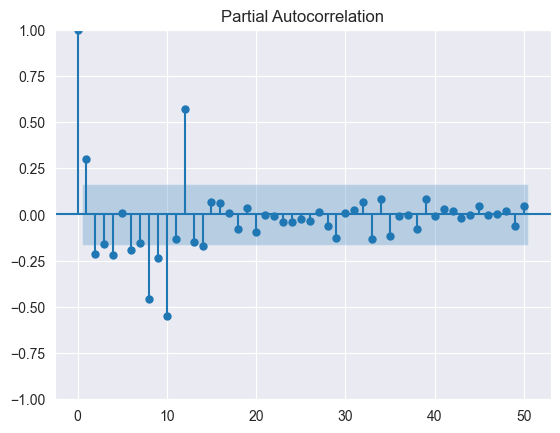

In [14]:
plot_pacf(diff_airline, lags=50)
plt.show()

In [15]:
airline

Period
1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
              ...  
1960-08-01    606.0
1960-09-01    508.0
1960-10-01    461.0
1960-11-01    390.0
1960-12-01    432.0
Freq: MS, Name: Number of airline passengers, Length: 144, dtype: float64

In [16]:
diff_airline

Period
1949-02-01     6.0
1949-03-01    14.0
1949-04-01    -3.0
1949-05-01    -8.0
1949-06-01    14.0
              ... 
1960-08-01   -16.0
1960-09-01   -98.0
1960-10-01   -47.0
1960-11-01   -71.0
1960-12-01    42.0
Freq: MS, Name: Number of airline passengers, Length: 143, dtype: float64

In [17]:
diff_decomposed = seasonal_decompose(diff_airline.dropna(), period=12)

Text(0.5, 1.0, 'Residual')

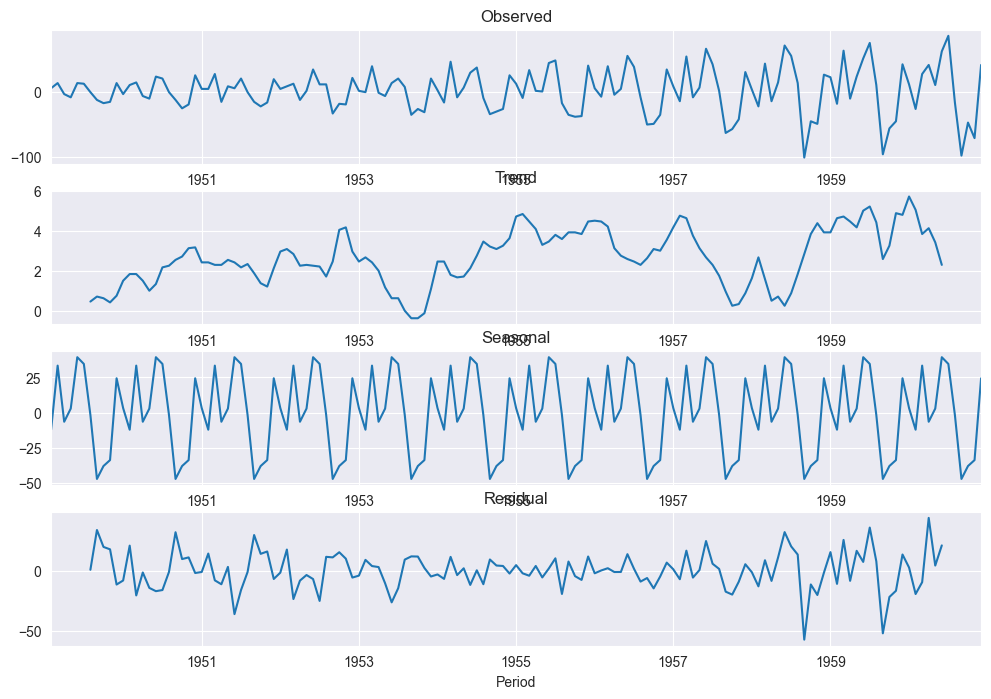

In [18]:
# make the x axis legend only at the lowest plot
fig, axes = plt.subplots(4, 1, figsize=(12, 8))
diff_decomposed.observed.plot(ax=axes[0], legend=False)
axes[0].set_title('Observed')
diff_decomposed.trend.plot(ax=axes[1], legend=False)
axes[1].set_title('Trend')
diff_decomposed.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_title('Seasonal')
diff_decomposed.resid.plot(ax=axes[3], legend=False)
axes[3].set_title('Residual')

## 2 Výběr strategie předpovídání

V této části vyzkoušíme několik prognostických přístupů a vyhodnotíme, který z nich je nejlepší

### 2.1 Trénování modelu a křížové ověřování

Pro výběr modelu musíme zvolit vhodnou strategii pro trénování modelu a křížovou validaci. Proces trénování znamená výběr nejvhodnější sady parametrů modelu tím, že necháme model zobrazit nové podmnožiny dat. Proces křížové validace slouží k vyhodnocení výkonnosti modelu na nezobrazených datech. U časových řad musíme být opatrní, aby nedošlo k úniku informací z budoucnosti do minulosti. K tomu budeme používat následující strategii:

- Trénujeme model na prvních 80 % dat.
- Vyhodnocení modelu na posledních 20 % dat.

In [19]:
train_size = int(0.8 * len(airline))
train_index = airline.index[:train_size]
test_index = airline.index[train_size:]

In [20]:
airline_train = airline.loc[train_index]
airline_test = airline.loc[test_index]
print(f"Training data size: {len(airline_train)}, Test data size: {len(airline_test)}")

Training data size: 115, Test data size: 29


In [21]:
airline_train.index[-1] < airline_test.index[0]

True

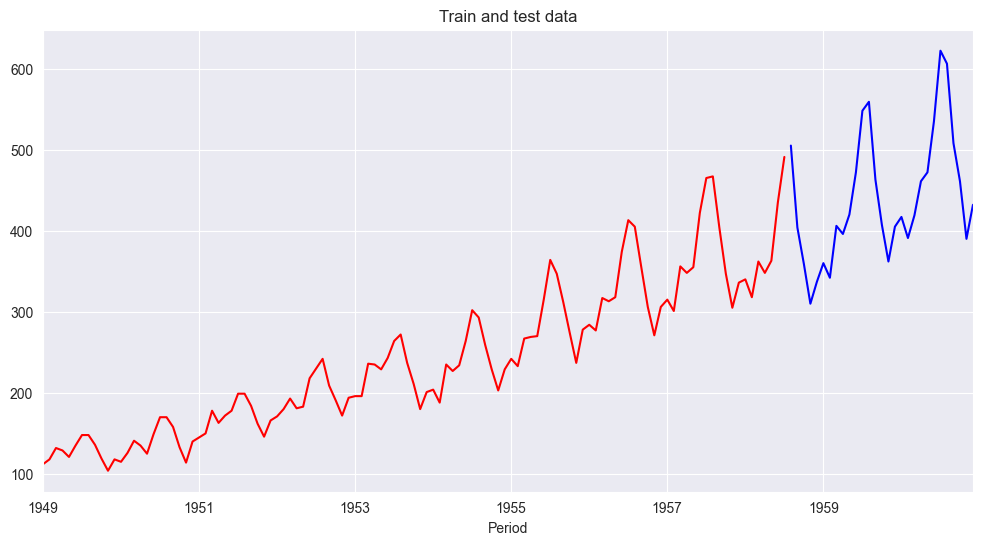

In [22]:
# let's plot the train and test data into the same plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
airline_train.plot(ax=ax, color="red", title="Train and test data")
airline_test.plot(ax=ax, color="blue")
plt.show()

### 2.2 Lineární regrese

Každý, kdo se někdy zúčastnil úvodního kurzu strojového učení, se jistě setkal s lineární regresí. Tato metoda vysvětluje cílovou proměnnou pomocí lineární kombinace funkcí, přičemž volí takové přizpůsobení, které minimalizuje součet čtverců reziduí (chyb). V našem případě budeme jako rys používat časový index a jako cílovou proměnnou počet cestujících. V další buňce zavedeme proměnnou čas, která bude použita jako kovariát. Poté dosadíme základní lineární regresní model a předpovíme

In [23]:
airline_regression = pd.DataFrame(airline).assign(time=[i + 1 for i in range(len(airline))])
airline_regression

,Number of airline passengers,time
Period,,
1949-01-01,112.0,1
1949-02-01,118.0,2
1949-03-01,132.0,3
1949-04-01,129.0,4
1949-05-01,121.0,5
...,...,...
1960-08-01,606.0,140
1960-09-01,508.0,141
1960-10-01,461.0,142


In [24]:
model = LinearRegression()
model.fit(X=airline_regression.loc[train_index, ['time']],
          y=airline_regression.loc[train_index,'Number of airline passengers'])

LinearRegression()

In [25]:
pred_regression = pd.DataFrame({'Number of airline passengers': model.predict(airline_regression.loc[test_index, ['time']]),
                       'Period': test_index}).set_index("Period")

In [26]:
full_regression = pd.concat([pd.DataFrame(airline).assign(data_type="actual"), pd.DataFrame(pred_regression).assign(data_type="regression_forecast")])

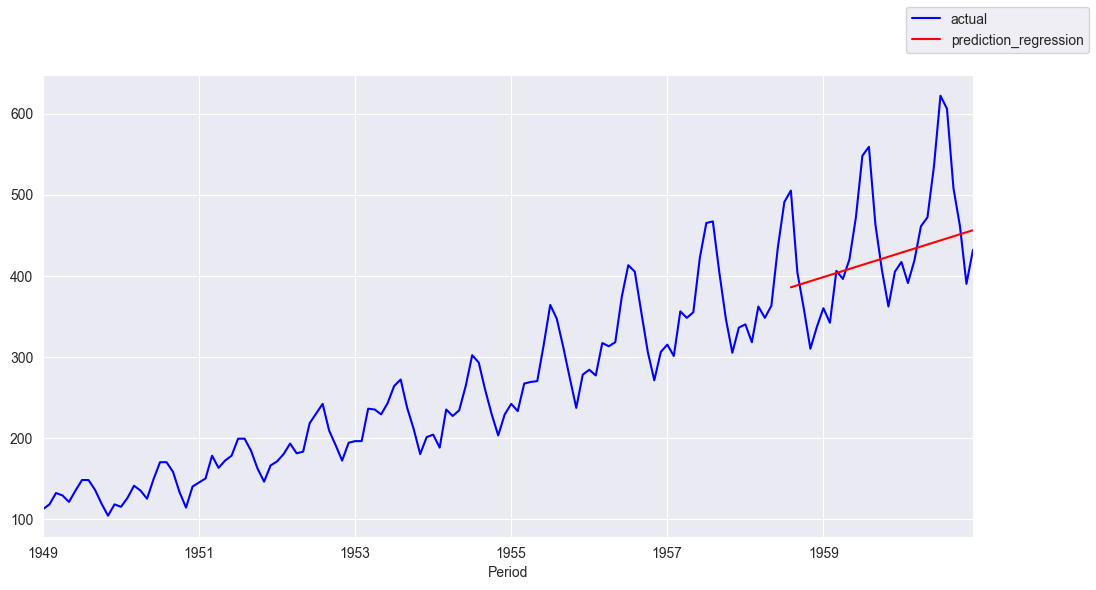

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
full_regression.query('data_type == "actual"')['Number of airline passengers'].plot(ax=ax, color='blue', label='actual')
full_regression.query('data_type == "regression_forecast"')['Number of airline passengers'].plot(ax=ax, color='red', label='prediction_regression')
fig.legend()
plt.show()

### 2.3 Předpověď pomocí trendu a sezónnosti

Viděli jsme, že lineární regrese nedokáže zachytit sezónní vzorce našich dat a možná budeme muset použít sofistikovanější model. V této části použijeme trend a sezónnost k předpovědi budoucích hodnot časové řady.


In [28]:
df_trend = pd.concat([airline_decomposed.trend, airline_decomposed.seasonal], axis=1).assign(
    time=[i + 1 for i in range(len(airline_decomposed.trend))])


In [29]:
model = LinearRegression()
y = df_trend.loc[train_index]['trend'].dropna()
X = df_trend.loc[y.index, ['time']].dropna()
model.fit(X=X, y=y)

LinearRegression()

In [30]:
y_pred = model.predict(df_trend.loc[test_index, ['time']])  + df_trend.loc[test_index, 'seasonal']
y_pred

Period
1958-08-01    449.914402
1958-09-01    406.176096
1958-10-01    371.577941
1958-11-01    341.191908
1958-12-01    368.730117
1959-01-01    375.166053
1959-02-01    366.291383
1959-03-01    402.803077
1959-04-01    399.572346
1959-05-01    405.667373
1959-06-01    448.141188
1959-07-01    479.133943
1959-08-01    480.691091
1959-09-01    436.952785
1959-10-01    402.354630
1959-11-01    371.968597
1959-12-01    399.506805
1960-01-01    405.942742
1960-02-01    397.068072
1960-03-01    433.579766
1960-04-01    430.349035
1960-05-01    436.444062
1960-06-01    478.917877
1960-07-01    509.910632
1960-08-01    511.467780
1960-09-01    467.729474
1960-10-01    433.131319
1960-11-01    402.745285
1960-12-01    430.283494
Freq: MS, Name: seasonal, dtype: float64

In [31]:
pred_trend_seas = pd.DataFrame(y_pred).rename(columns={"seasonal": "Number of airline passengers"}).assign(data_type="trend_seas_forecast")

In [32]:
df_complete = pd.concat([pd.DataFrame(airline).assign(data_type="actual"), pred_trend_seas])

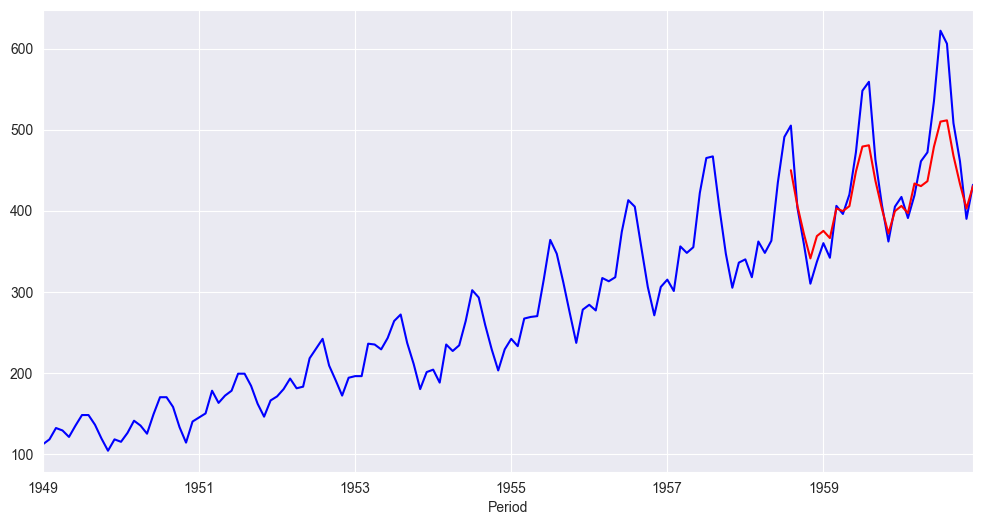

In [33]:
# plot the results
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
df_complete.query('data_type == "actual"')['Number of airline passengers'].plot(ax=ax, color='blue', label='actual')
df_complete.query('data_type == "trend_seas_forecast"')['Number of airline passengers'].plot(ax=ax, color='red', label='pred_trend')
plt.show()

### 3.4 Prediction using ARMA model

In [34]:
import pmdarima
forecaster = ARIMA(
    order=(1, 1, 0),
    seasonal_order=(0, 1, 0, 12),
    suppress_warnings=True)

forecaster.fit(airline.loc[train_index].reset_index(drop=True))
y_pred = forecaster.predict(fh=[i for i in range(1, len(test_index) + 1)])

In [35]:
pred_arima = pd.DataFrame(y_pred).set_index(test_index).assign(data_type="pred_arima")

In [36]:
df_arima_full = pd.concat([pd.DataFrame(airline).assign(data_type="actual"), pred_arima])

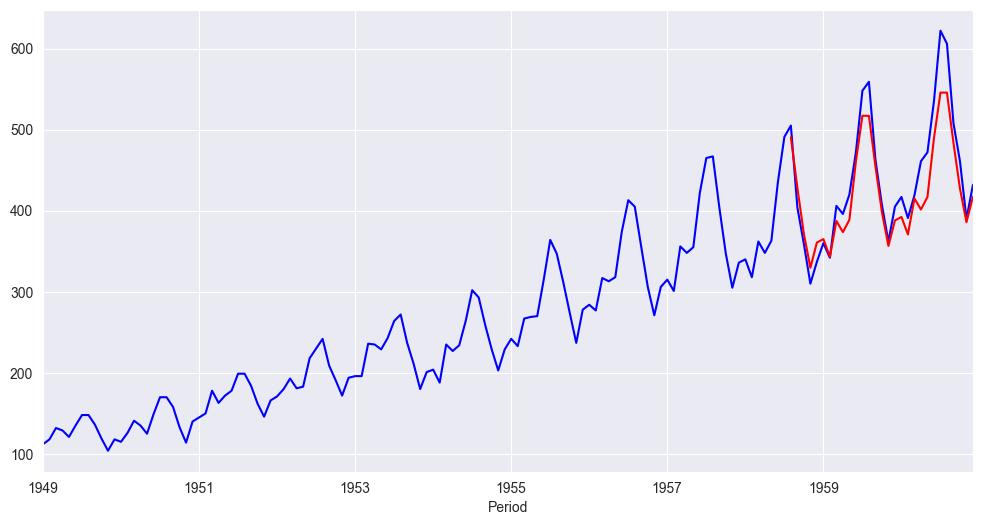

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
df_arima_full.query('data_type == "actual"')['Number of airline passengers'].plot(ax=ax, color='blue', label='actual')
df_arima_full.query('data_type == "pred_arima"')['Number of airline passengers'].plot(ax=ax, color='red', label='pred_arima')
plt.show()

Now that we've estimated 3 models, we can plot the results in a single plot:

In [38]:
df_preds_all = pd.DataFrame(index=test_index)
df_preds_all = df_preds_all.assign(pred_arima=pred_arima['Number of airline passengers'],
                    pred_trend=pred_trend_seas['Number of airline passengers'],
                    pred_regression=pred_regression['Number of airline passengers']).reset_index().melt(id_vars="Period",
                                                                                                var_name="data_type",
                                                                                                value_name="Number of airline passengers").set_index("Period")
df_preds_all

,data_type,Number of airline passengers
Period,,
1958-08-01,pred_arima,490.572611
1958-09-01,pred_arima,428.306359
1958-10-01,pred_arima,371.392376
1958-11-01,pred_arima,329.611116
1958-12-01,pred_arima,360.802661
...,...,...
1960-08-01,pred_regression,446.060743
1960-09-01,pred_regression,448.574315
1960-10-01,pred_regression,451.087888


In [39]:
df_all = pd.concat([pd.DataFrame(airline).assign(data_type="actuals"),
                    df_preds_all], axis=0).reset_index().sort_values(['Period', 'data_type']).set_index("Period")

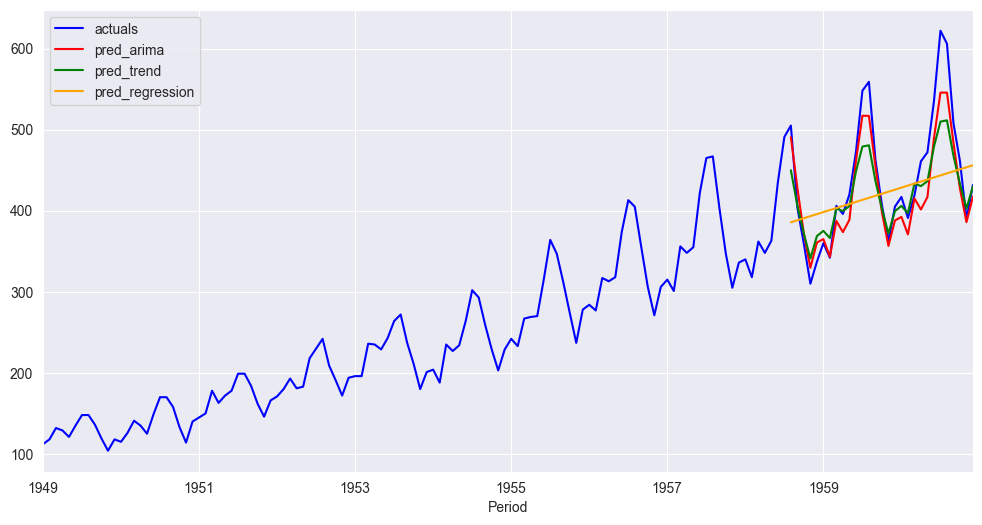

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
df_all.query('data_type == "actuals"')['Number of airline passengers'].plot(ax=ax, color='blue', label='actuals')
df_all.query('data_type == "pred_arima"')['Number of airline passengers'].plot(ax=ax, color='red', label='pred_arima')
df_all.query('data_type == "pred_trend"')['Number of airline passengers'].plot(ax=ax, color='green', label='pred_trend')
df_all.query('data_type == "pred_regression"')['Number of airline passengers'].plot(ax=ax, color='orange', label='pred_regression')
ax.legend()
plt.show()

## 3 Evaluating the models

## 3 Vyhodnocení modelů

V předchozí části jsme odhadli několik modelů a postupně jsme zlepšovali jejich výkonnost. Při řízení strategických rozhodnutí však obchodní strana obvykle chce mít jediný zdroj pravdy. Za tímto účelem musíme modely vyhodnotit a vybrat ten nejlepší. Výběr modelu je obvykle založen na nějaké metrice, která porovnává skutečné a předpovídané hodnoty. V případě časových řad obvykle používáme následující metriky:
- Střední absolutní procentní chyba (MAPE): průměr absolutních procentních chyb.
- Střední kvadratická chyba (MSE): průměr kvadratických chyb.
- Kořenová střední kvadratická chyba (RMSE): odmocnina z průměru kvadratických chyb.

Vždy je důležité vybrat metriku, která je pro daný obchodní problém nejrelevantnější. Mohli byste uvést nějaké zdůvodnění výběru metriky za následujícími scénáři?
- Podnik potřebuje mít přesné plánování ročního rozpočtu
- Podnik se rozhoduje každý měsíc a upravuje očekávání z předchozího měsíce.

In [41]:
# Which model performs the best on average?
y_true = airline_test.loc[test_index]

y_arima = pred_arima.loc[test_index, 'Number of airline passengers']
y_trend = pred_trend_seas.loc[test_index, 'Number of airline passengers']
y_regression = pred_regression.loc[test_index, 'Number of airline passengers']

In [42]:
for y_pred, name in zip([y_arima, y_trend, y_regression], ['arima', 'trend', 'regression']):
    print(f"MAPE for {name}: {mean_absolute_percentage_error(y_true, y_pred)}")

MAPE for arima: 0.053132077085516205
MAPE for trend: 0.06102020954841454
MAPE for regression: 0.1207138013428198


How about aggregating the errors over the whole year and only then calculating the MAPE?

In [43]:
# create a function which aggregates the errors over the year
def mape_yearly(y_true, y_pred):
    df_res_agg = pd.DataFrame(index=y_true.index)
    df_res_agg['true'] = y_true
    df_res_agg['pred'] = y_pred
    df_res_agg['year'] = df_res_agg.index.year

    df_res_agg = df_res_agg.groupby('year').sum()
    return mean_absolute_percentage_error(df_res_agg['true'], df_res_agg['pred'])

In [44]:
for y_pred, name in zip([y_arima, y_trend, y_regression], ['arima', 'trend', 'regression']):
    print(f"Yearly MAPE for {name}: {mape_yearly(y_true, y_pred)}")

Yearly MAPE for arima: 0.0483428507206534
Yearly MAPE for trend: 0.037029916762411526
Yearly MAPE for regression: 0.0430816864829086


# Přístup strojového učení k předpovídání časových řad

V této části si ukážeme jednoduchý příklad, jak přistupovat k předpovídání časových řad pomocí funkce hrubého strojového učení. Tento přístup je užitečný zejména tehdy, když potřebujeme porovnat více modelů, z nichž každý má několik parametrů, které lze **vyladit** tak, aby co nejlépe vyhovovaly různým časovým řadám.

In [45]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series

C:\Users\A115601930\DT_repositories\DelPy-TDG\venv\lib\site-packages\sktime\forecasting\base\_fh.py:415: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  if freq_from_self != freq_from_obj:
C:\Users\A115601930\DT_repositories\DelPy-TDG\venv\lib\site-packages\sktime\forecasting\base\_fh.py:172: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return to_offset(obj)
C:\Users\A115601930\DT_repositories\DelPy-TDG\venv\lib\site-packages\sktime\utils\datetime.py:73: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
C:\Users\A115601930\DT_repositories\DelPy-TDG\venv\lib\site-packages\sktime\forecasting\base\_fh.py:172: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return to_offset(obj)
C:\Users\A115601930\DT_repositories\DelPy-TDG\venv\lib\

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

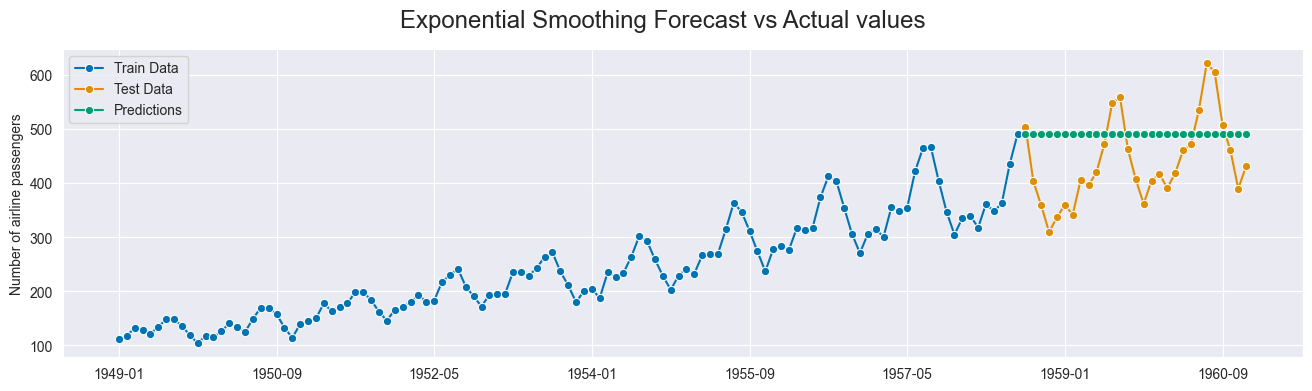

In [46]:
# Convert the date index to PeriodIndex required by sktime
airline_train.index = pd.PeriodIndex(airline_train.index, freq="M")
airline_test.index = pd.PeriodIndex(airline_test.index, freq="M")

# Define forecasting horizon (how far ahead we want to predict)
fh = ForecastingHorizon(airline_test.index, is_relative=False)

# Initialize model
model = ExponentialSmoothing()

# Fit the model on the training data
model.fit(airline_train)

# Make predictions
airline_pred_es = model.predict(fh)

# Plot the predictions against the actual test set
plot_series(airline_train, airline_test, airline_pred_es, labels=["Train Data", "Test Data", "Predictions"], title="Exponential Smoothing Forecast vs Actual values")

#### Strategie křížového ověřování

Modely můžeme hodnotit pomocí různých strategií křížového ověřování (CV). Prozkoumejme CV s rozšiřujícím se oknem a CV s posuvným oknem.

In [47]:
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from sktime.split import ExpandingWindowSplitter
from sktime.split import SlidingWindowSplitter

In [48]:
def plot_windows(y, train_windows, test_windows, title=""):
    """Visualize training and test windows."""
    simplefilter("ignore", category=UserWarning)

    def get_y(length, split):
        # Create a constant vector based on the split for y-axis."""
        return np.ones(length) * split

    n_splits = len(train_windows)
    n_timepoints = len(y)
    len_test = len(test_windows[0])

    train_color, test_color = sns.color_palette("colorblind")[:2]

    fig, ax = plt.subplots(figsize=plt.figaspect(0.3))

    for i in range(n_splits):
        train = train_windows[i]
        test = test_windows[i]

        ax.plot(
            np.arange(n_timepoints), get_y(n_timepoints, i), marker="o", c="lightgray"
        )
        ax.plot(
            train,
            get_y(len(train), i),
            marker="o",
            c=train_color,
            label="Window",
        )
        ax.plot(
            test,
            get_y(len_test, i),
            marker="o",
            c=test_color,
            label="Forecasting horizon",
        )
    ax.invert_yaxis()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set(
        title=title,
        ylabel="Window number",
        xlabel="Time",
        xticklabels=y.index,
    )
    # remove duplicate labels/handles
    handles, labels = ((leg[:2]) for leg in ax.get_legend_handles_labels())
    ax.legend(handles, labels)

In [49]:
def get_windows(y, cv):
    """Generate windows."""
    train_windows = []
    test_windows = []
    for i, (train, test) in enumerate(cv.split(y)):
        train_windows.append(train)
        test_windows.append(test)
    return train_windows, test_windows

In [50]:
# Expanding window cross-validation
expanding_cv = ExpandingWindowSplitter(initial_window=24, step_length=12, fh=np.arange(1, 13))

n_splits = expanding_cv.get_n_splits(y)
print(f"Number of Folds = {n_splits}")

Number of Folds = 7


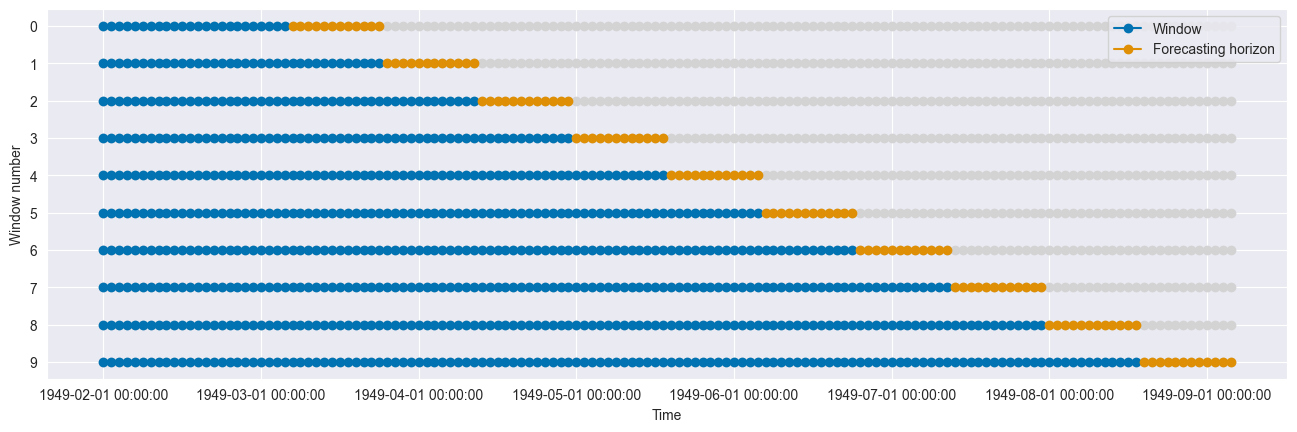

In [51]:
train_windows, test_windows = get_windows(airline, expanding_cv)
plot_windows(airline, train_windows, test_windows)

In [52]:
# Sliding window cross-validation
sliding_cv = SlidingWindowSplitter(window_length=24, step_length=12, fh=np.arange(1, 13))

n_splits = sliding_cv.get_n_splits(y)
print(f"Number of Folds = {n_splits}")

Number of Folds = 7


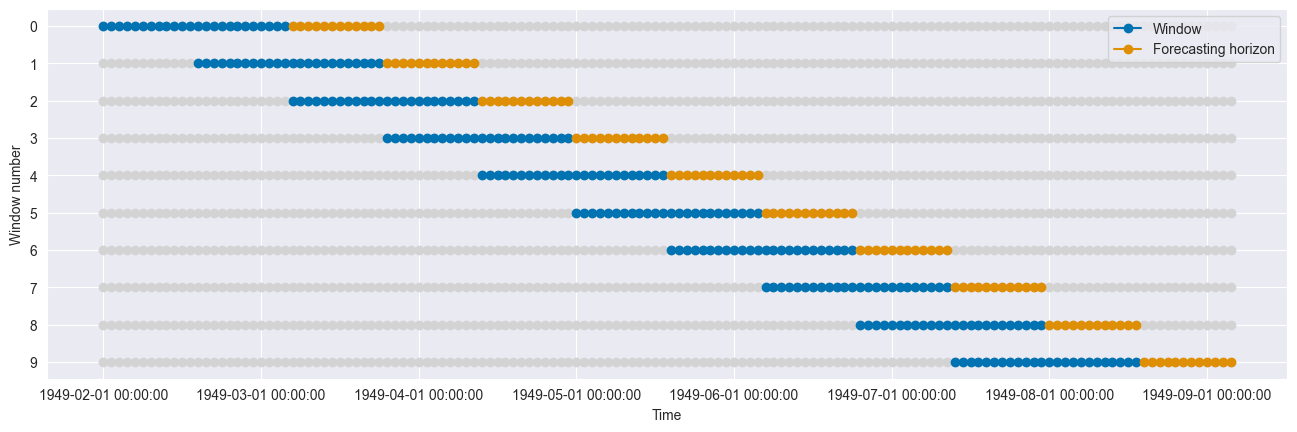

In [53]:
train_windows, test_windows = get_windows(airline, sliding_cv)
plot_windows(airline, train_windows, test_windows)

#### Hyperparameter Tuning

We can perform backtesting to evaluate our model over multiple time periods using cross-validation.

In [54]:
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.performance_metrics.forecasting import MeanSquaredError

In [55]:
# Define error metric
rmse = MeanSquaredError(square_root=True)

# Define parameter grid for tuning ExponentialSmoothing model defined earlier
param_grid = {'smoothing_level': [0.2, 0.5, 0.8]}

def train_and_plot(cv_strategy):
    # Set up grid search with cross-validation
    gscv = ForecastingGridSearchCV(forecaster=model, param_grid=param_grid, cv=cv_strategy, scoring=rmse)
    
    # Fit the grid search
    gscv.fit(airline_train)
    
    # Get the best found parameters
    print(f"Performances on individual folds: {gscv.cv_results_}")
    print(f"Best params: {gscv.best_params_}")
    
    # Forecast using the best model
    airline_pred_es = gscv.predict(fh)
    
    # Plot the predictions against the actual test set
    plot_series(airline_train, airline_test, airline_pred_es, labels=["Train Data", "Test Data", "Predictions"], title=f"Backtesting with Cross-Validation ({cv_strategy})")
    return airline_pred_es

Let's first try using **ExpandingWindow**

Performances on individual folds:    mean_test_MeanSquaredError  mean_fit_time  mean_pred_time  \
0                   50.031183       0.006021        0.006940   
1                   56.662284       0.005194        0.006199   
2                   58.198497       0.005114        0.005888   

                     params  rank_test_MeanSquaredError  
0  {'smoothing_level': 0.2}                         1.0  
1  {'smoothing_level': 0.5}                         2.0  
2  {'smoothing_level': 0.8}                         3.0  
Best params: {'smoothing_level': 0.2}


C:\Users\A115601930\DT_repositories\DelPy-TDG\venv\lib\site-packages\sktime\forecasting\base\_fh.py:415: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  if freq_from_self != freq_from_obj:
C:\Users\A115601930\DT_repositories\DelPy-TDG\venv\lib\site-packages\sktime\forecasting\base\_fh.py:172: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return to_offset(obj)
C:\Users\A115601930\DT_repositories\DelPy-TDG\venv\lib\site-packages\sktime\utils\datetime.py:73: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
C:\Users\A115601930\DT_repositories\DelPy-TDG\venv\lib\site-packages\sktime\forecasting\base\_fh.py:172: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return to_offset(obj)
C:\Users\A115601930\DT_repositories\DelPy-TDG\venv\lib\

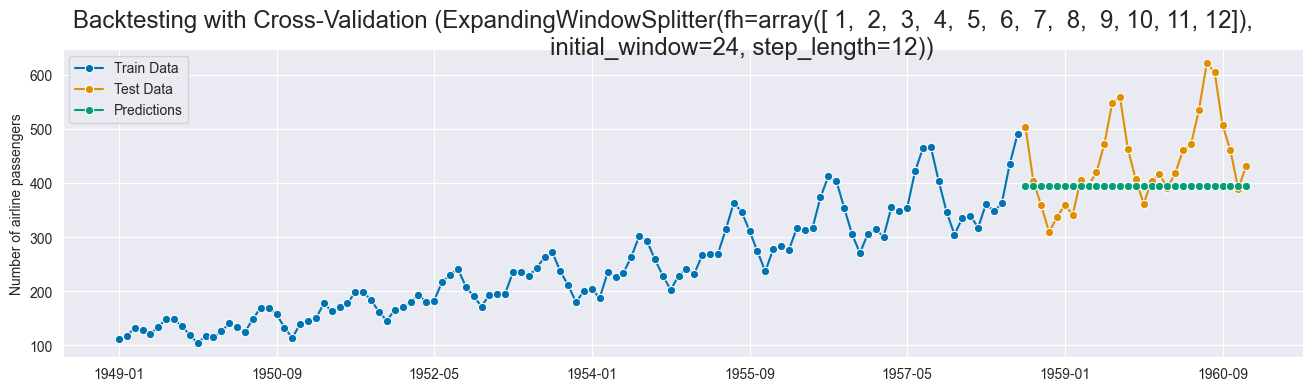

In [56]:
airline_train_es = train_and_plot(expanding_cv)

And not with **SlidingWindow**

Performances on individual folds:    mean_test_MeanSquaredError  mean_fit_time  mean_pred_time  \
0                   49.967920       0.004928        0.005347   
1                   56.662284       0.005307        0.005973   
2                   58.198497       0.006305        0.006481   

                     params  rank_test_MeanSquaredError  
0  {'smoothing_level': 0.2}                         1.0  
1  {'smoothing_level': 0.5}                         2.0  
2  {'smoothing_level': 0.8}                         3.0  
Best params: {'smoothing_level': 0.2}


C:\Users\A115601930\DT_repositories\DelPy-TDG\venv\lib\site-packages\sktime\forecasting\base\_fh.py:415: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  if freq_from_self != freq_from_obj:
C:\Users\A115601930\DT_repositories\DelPy-TDG\venv\lib\site-packages\sktime\forecasting\base\_fh.py:172: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return to_offset(obj)
C:\Users\A115601930\DT_repositories\DelPy-TDG\venv\lib\site-packages\sktime\utils\datetime.py:73: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
C:\Users\A115601930\DT_repositories\DelPy-TDG\venv\lib\site-packages\sktime\forecasting\base\_fh.py:172: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return to_offset(obj)
C:\Users\A115601930\DT_repositories\DelPy-TDG\venv\lib\

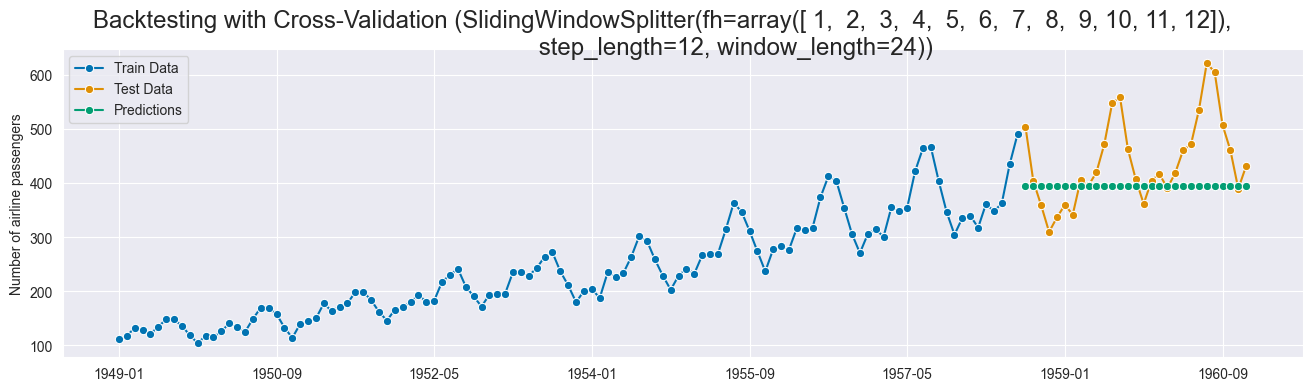

In [57]:
airline_train_es = train_and_plot(sliding_cv)

#### Srovnání více modelů

Můžete také porovnat různé modely (např. ARIMA, Exponenciální vyhlazování, Náhodný les) a jejich výkonnost.

Nejdříve nastavíme model **ARIMA**.

In [58]:
from sktime.forecasting.arima import ARIMA
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import make_reduction

In [59]:
# Initialize a new model (ARIMA)
arima_model = ARIMA()

# Define parameter grid and GSCV Forecaster
param_grid_arima = {'order': [(1, 0, 0), (1, 0, 1), (1, 1, 1), (2, 1, 1), (2, 1, 2)],
                    'seasonal_order': [(0, 1, 0, 12), (1, 1, 0, 12), (1, 1, 1, 12)]}

gscv_arima = ForecastingGridSearchCV(forecaster=arima_model, param_grid=param_grid_arima, cv=expanding_cv, scoring=rmse)
    
# Fit the grid search with ARIMA configuration on training data
gscv_arima.fit(airline_train)
print(f"Best parameters: {gscv_arima.best_params_}")

# Make predictions using ARIMA
airline_pred_arima = gscv_arima.predict(fh)

Best parameters: {'order': (2, 1, 1), 'seasonal_order': (1, 1, 0, 12)}


C:\Users\A115601930\DT_repositories\DelPy-TDG\venv\lib\site-packages\sktime\forecasting\base\_fh.py:415: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  if freq_from_self != freq_from_obj:
C:\Users\A115601930\DT_repositories\DelPy-TDG\venv\lib\site-packages\sktime\forecasting\base\_fh.py:172: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return to_offset(obj)
C:\Users\A115601930\DT_repositories\DelPy-TDG\venv\lib\site-packages\sktime\forecasting\base\_fh.py:415: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  if freq_from_self != freq_from_obj:
C:\Users\A115601930\DT_repositories\DelPy-TDG\venv\lib\site-packages\sktime\forecasting\base\_fh.py:172: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return to_offset(obj)
C:\Users\A115601930\DT_repositories\DelPy-TDG\venv\lib\site-

A nyní vyzkoušíme **nejbližší sousedy** (ML, nikoli statistický model).

In [60]:
# Initialize a new model (KNN)
knn_regressor = make_reduction(KNeighborsRegressor(), strategy="recursive")

# Define parameter grid and GSCV Forecaster
param_grid_knn = {"estimator__n_neighbors": np.arange(1, 8)}

gscv_knn = ForecastingGridSearchCV(forecaster=knn_regressor, param_grid=param_grid_knn, cv=expanding_cv)
    
# Fit the grid search with KNN configuration on training data
gscv_knn.fit(airline_train)
print(f"Best parameters: {gscv_knn.best_params_}")

# Make predictions using KNN
airline_pred_knn = gscv_knn.predict(fh)

Best parameters: {'estimator__n_neighbors': 1}


C:\Users\A115601930\DT_repositories\DelPy-TDG\venv\lib\site-packages\sktime\forecasting\base\_fh.py:415: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  if freq_from_self != freq_from_obj:
C:\Users\A115601930\DT_repositories\DelPy-TDG\venv\lib\site-packages\sktime\utils\datetime.py:73: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
C:\Users\A115601930\DT_repositories\DelPy-TDG\venv\lib\site-packages\sktime\forecasting\base\_fh.py:172: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return to_offset(obj)
C:\Users\A115601930\DT_repositories\DelPy-TDG\venv\lib\site-packages\sktime\forecasting\base\_fh.py:415: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  if freq_from_self != freq_from_obj:
C:\Users\A115601930\DT_repositories\DelPy

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

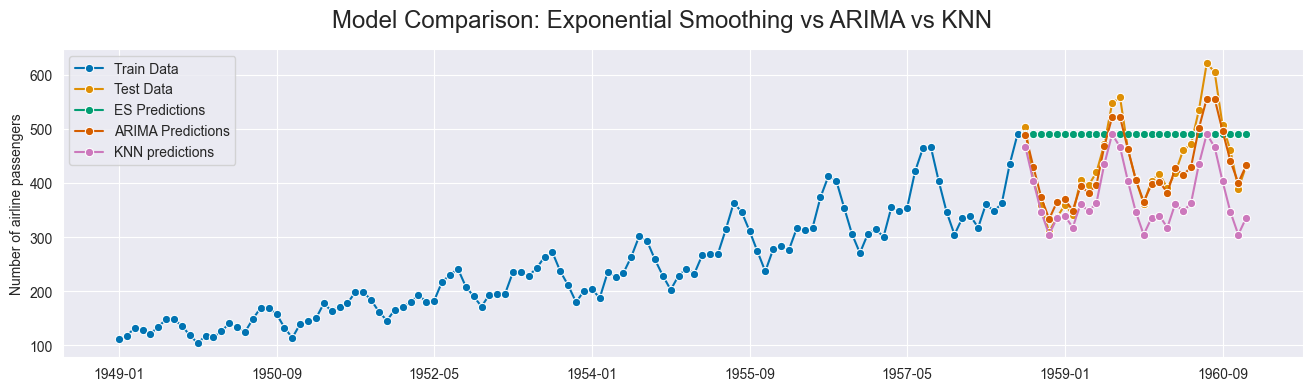

In [61]:
plot_series(airline_train, airline_test, airline_pred_es, airline_pred_arima, airline_pred_knn, labels=["Train Data", "Test Data", "ES Predictions", "ARIMA Predictions", "KNN predictions"], title="Model Comparison: Exponential Smoothing vs ARIMA vs KNN")

#### Vyhodnocení modelu a metriky chyb

Pro vyhodnocení výkonnosti modelu můžeme vypočítat metriky chyb, jako jsou MAPE (Mean Absolute Percentage Error) a RMSE (Root Mean Squared Error).

In [62]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError, MeanSquaredError

In [63]:
mape = MeanAbsolutePercentageError()
rmse = MeanSquaredError(square_root=True)

for y_pred, name in zip([airline_pred_es, airline_pred_arima, airline_pred_knn], ['ES', 'ARIMA', 'KNN']):
    print(f"Mean Absolute Percentage Error for {name}: {mape(airline_test, y_pred)}")
    
for y_pred, name in zip([airline_pred_es, airline_pred_arima, airline_pred_knn], ['ES', 'ARIMA', 'KNN']):
    print(f"Root Mean Squared Error for {name}: {rmse(airline_test, y_pred)}")

Mean Absolute Percentage Error for ES: 0.20182545156232284
Mean Absolute Percentage Error for ARIMA: 0.04229420489965084
Mean Absolute Percentage Error for KNN: 0.1403790054823889
Root Mean Squared Error for ES: 93.06864683063684
Root Mean Squared Error for ARIMA: 25.114107181508192
Root Mean Squared Error for KNN: 75.23388818235092


#### Intervaly předpovědi

Pro lepší pochopení pravděpodobnostní povahy předpovědí můžeme použít předpovědní intervaly. Pomocí nich můžeme zohlednit nejistotu předpovědi a náhodné kolísání dat.

In [95]:
y = load_airline()

y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

fh = np.arange(1, len(y_test.index))

In [96]:
best_forecaster = ARIMA(order=(2, 1, 1), seasonal_order=(1, 1, 0, 12))
best_forecaster.fit(y_train, fh=fh) 

ARIMA(order=(2, 1, 1), seasonal_order=(1, 1, 0, 12))

In [97]:
coverage = 0.9
y_pred_ints = best_forecaster.predict_interval(coverage=coverage)
y_pred_ints

C:\Users\A115601930\DT_repositories\DelPy-TDG\venv\lib\site-packages\sktime\forecasting\base\_fh.py:415: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  if freq_from_self != freq_from_obj:
C:\Users\A115601930\DT_repositories\DelPy-TDG\venv\lib\site-packages\sktime\forecasting\base\_fh.py:172: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return to_offset(obj)
C:\Users\A115601930\DT_repositories\DelPy-TDG\venv\lib\site-packages\sktime\forecasting\base\_fh.py:415: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  if freq_from_self != freq_from_obj:
C:\Users\A115601930\DT_repositories\DelPy-TDG\venv\lib\site-packages\sktime\forecasting\base\_fh.py:172: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return to_offset(obj)
C:\Users\A115601930\DT_repositories\DelPy-TDG\venv\lib\site-

Number of airline passengers            
                                 0.9            
                               lower       upper
1958-08                   474.565907  505.700106
1958-09                   410.251553  451.026065
1958-10                   348.698723  399.451026
1958-11                   304.823301  362.763832
1958-12                   332.790462  397.727549
1959-01                   334.913288  405.828453
1959-02                   311.267201  387.880208
1959-03                   354.456501  436.267089
1959-04                   338.993927  425.750474
1959-05                   350.884103  442.285516
1959-06                   420.236248  516.077094
1959-07                   472.650967  572.723308
1959-08                   465.159996  579.739291
1959-09                   399.908888  525.580733
1959-10                   337.782869  474.964885
1959-11                   292.579685  439.656092
1959-12                   319.396956  476.150406
1960-01                   320.173718  485.808161
1960-02                   295.188552  469.384163
1960-03                   336.950013  519.228959
1960-04                   320.186907  510.249642
1960-05                   331.031613  528.546189
1960-06                   399.315785  604.025881
1960-07                   450.823878  662.476420
1960-08                   443.212612  669.951108
1960-09                   377.420142  616.896189
1960-10                   314.690960  567.338221
1960-11                   268.727524  533.289085

C:\Users\A115601930\DT_repositories\DelPy-TDG\venv\lib\site-packages\sktime\forecasting\base\_fh.py:415: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  if freq_from_self != freq_from_obj:
C:\Users\A115601930\DT_repositories\DelPy-TDG\venv\lib\site-packages\sktime\forecasting\base\_fh.py:172: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return to_offset(obj)
C:\Users\A115601930\DT_repositories\DelPy-TDG\venv\lib\site-packages\sktime\forecasting\base\_fh.py:415: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  if freq_from_self != freq_from_obj:
C:\Users\A115601930\DT_repositories\DelPy-TDG\venv\lib\site-packages\sktime\forecasting\base\_fh.py:172: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return to_offset(obj)
C:\Users\A115601930\DT_repositories\DelPy-TDG\venv\lib\site-

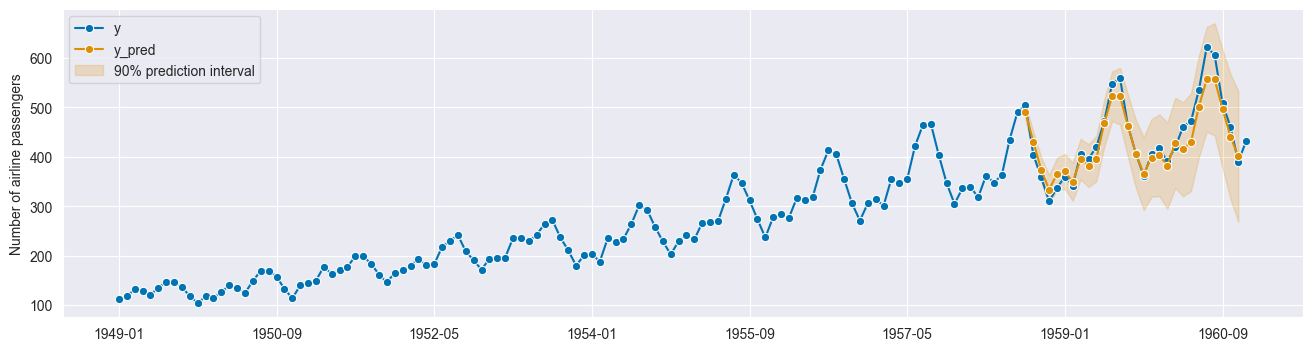

In [99]:
y_pred = best_forecaster.predict()

fig, ax = plot_series(
    y, y_pred, labels=["y", "y_pred"], pred_interval=y_pred_ints
)

## Další kroky

To, co jsme si dnes ukázali, samozřejmě nejsou všechny kroky potřebné k dosažení co nejlepší předpovědi pro tuto jedinou časovou řadu. Praktik by se mohl pokusit ještě o více věcí, které by mohly zlepšit konečnou předpověď.

Ještě by se dalo:
- vyzkoušet různé transformace dat (detrending, deseasonalizace, škálování atd.).
- zkusit rozšířit prostor hyperparametrů nebo vyladit různé hyperparametry již použitých modelů
- vyzkoušet různé modely (PolynomialTrendForecaster, STLForecaster, ThetaForecaster, TBATS, Prophet, RandomForest, XGBoost a mnoho dalších).


